
# MNIST MLP — **Same Architecture as Your Updated Notebook** (PyTorch, CUDA/MPS)

Architecture (matching your Keras model):
- **Dense 784 → 100**, activation **sigmoid**
- **Dense 100 → 49**, activation **sigmoid**
- **Dense 49 → 10**, activation **softmax** (via `CrossEntropyLoss` on logits)

What you’ll see:
1. 5×5 sample digit grid  
2. Training with CrossEntropyLoss (CUDA/**MPS** if available)  
3. **Weight visualizations** with maximum clarity:
   - **First-layer filters** (100 weight maps, show top 25)  
   - **Second-layer receptive fields** back‑projected to input (49 maps, show top 25)  
   - **Class‑effective templates** (approx. \(W_3 \cdot W_2 \cdot W_1\); one per class)  
   - High‑res plots, light **L2 weight decay**, optional **Gaussian blur**, diverging colormap centered at 0, zero‑level contour


> If needed, install: `pip install torch torchvision matplotlib`

In [19]:

import os, random, math, numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Reproducibility
SEED = 0
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Device selection: CUDA -> MPS -> CPU
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

DEVICE = get_device()
print("Using device:", DEVICE)
if DEVICE.type == "cuda":
    print("CUDA:", torch.cuda.get_device_name(0))
elif DEVICE.type == "mps":
    print("Apple Metal (MPS) backend active")


Using device: cuda
CUDA: NVIDIA GeForce RTX 3090


## Data — MNIST

In [20]:

transform = transforms.Compose([transforms.ToTensor()])  # [0,1]
root = os.path.join('.', 'data')

train_ds = datasets.MNIST(root=root, train=True,  download=True, transform=transform)
test_ds  = datasets.MNIST(root=root, train=False, download=True, transform=transform)

BATCH_SIZE = 256
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

len(train_ds), len(test_ds)


(60000, 10000)

## 1) Visualize 25 digits (5×5)

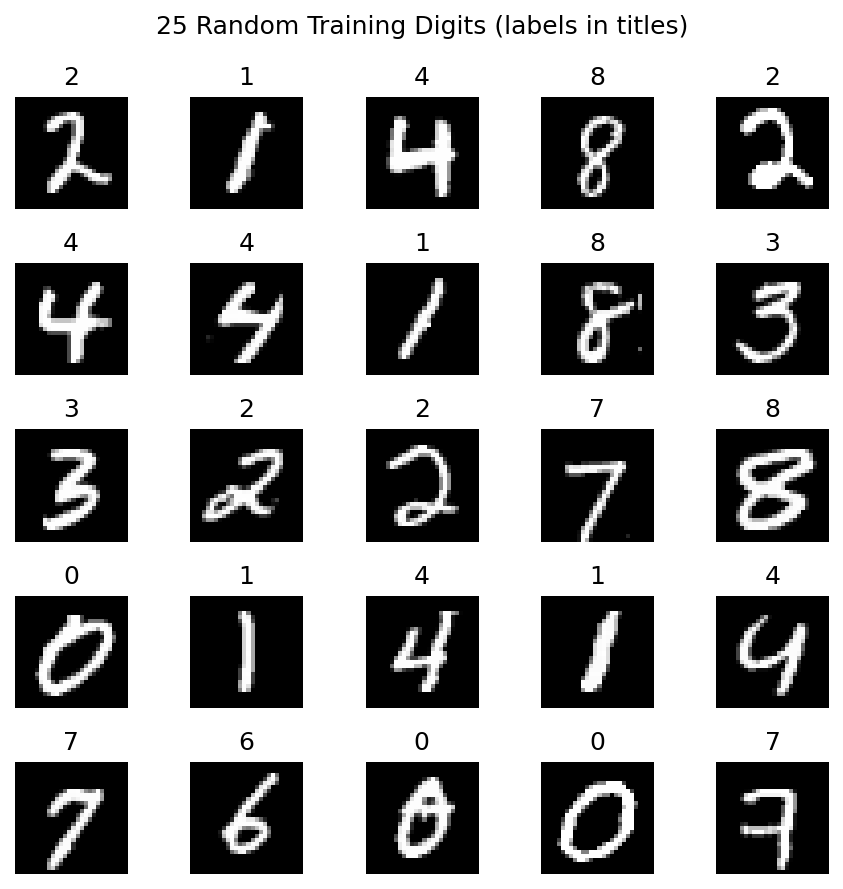

In [21]:

def show_grid(ds, rows=5, cols=5, seed=SEED):
    rng = np.random.default_rng(seed)
    idxs = rng.choice(len(ds), size=rows*cols, replace=False)
    fig, axes = plt.subplots(rows, cols, figsize=(6,6), dpi=150)
    fig.suptitle("25 Random Training Digits (labels in titles)")
    for ax, idx in zip(axes.ravel(), idxs):
        img, y = ds[idx]
        ax.imshow(img.squeeze(0), cmap="gray", interpolation="nearest")
        ax.set_title(str(y)); ax.axis("off")
    for ax in axes.ravel()[rows*cols:]:
        ax.axis("off")
    plt.tight_layout(); plt.show()

show_grid(train_ds, 5, 5)


## 2) Model — 784→100 (sigmoid) → 49 (sigmoid) → 10 (softmax)

In [22]:

class MLP_Sigmoid(nn.Module):
    def __init__(self, in_dim=28*28, h1=100, h2=49, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, h1, bias=True)
        self.fc2 = nn.Linear(h1, h2, bias=True)
        self.fc3 = nn.Linear(h2, num_classes, bias=True)
        self.act = nn.Sigmoid()

    def forward(self, x):
        if x.dim() == 4:  # (B,1,28,28) -> (B,784)
            x = x.view(x.size(0), -1)
        h1 = self.act(self.fc1(x))
        h2 = self.act(self.fc2(h1))
        logits = self.fc3(h2)  # raw logits; CrossEntropyLoss applies softmax
        return logits

model = MLP_Sigmoid().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # L2 for smoother weights


## 3) Train and evaluate

In [23]:

def accuracy(loader, model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb).argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    return correct/total

EPOCHS = 8
for epoch in range(1, EPOCHS+1):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
    if DEVICE.type == "mps":
        torch.mps.synchronize()
    tr, te = accuracy(train_loader, model), accuracy(test_loader, model)
    print(f"Epoch {epoch:02d}/{EPOCHS} | train_acc={tr*100:.2f}% | test_acc={te*100:.2f}%")


Epoch 01/8 | train_acc=86.00% | test_acc=86.73%
Epoch 02/8 | train_acc=90.76% | test_acc=91.02%
Epoch 03/8 | train_acc=92.63% | test_acc=92.73%
Epoch 04/8 | train_acc=93.64% | test_acc=93.69%
Epoch 05/8 | train_acc=94.67% | test_acc=94.45%
Epoch 06/8 | train_acc=95.41% | test_acc=95.03%
Epoch 07/8 | train_acc=95.88% | test_acc=95.51%
Epoch 08/8 | train_acc=96.24% | test_acc=95.76%


## 4) Weight visualization utilities

In [24]:

from matplotlib.colors import TwoSlopeNorm

@torch.no_grad()
def get_Wb(model):
    W1 = model.fc1.weight.detach().cpu().numpy()  # (100,784)
    b1 = model.fc1.bias.detach().cpu().numpy()
    W2 = model.fc2.weight.detach().cpu().numpy()  # (49,100)
    b2 = model.fc2.bias.detach().cpu().numpy()
    W3 = model.fc3.weight.detach().cpu().numpy()  # (10,49)
    b3 = model.fc3.bias.detach().cpu().numpy()
    return W1, b1, W2, b2, W3, b3

def gaussian_blur_np(img, sigma=0.9, k=7):
    ax = torch.arange(k) - k//2
    xx, yy = torch.meshgrid(ax, ax, indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel = (kernel / kernel.sum()).unsqueeze(0).unsqueeze(0)
    t = torch.from_numpy(img).float().unsqueeze(0).unsqueeze(0)
    out = F.conv2d(t, kernel, padding=k//2).squeeze().numpy()
    return out


### W1

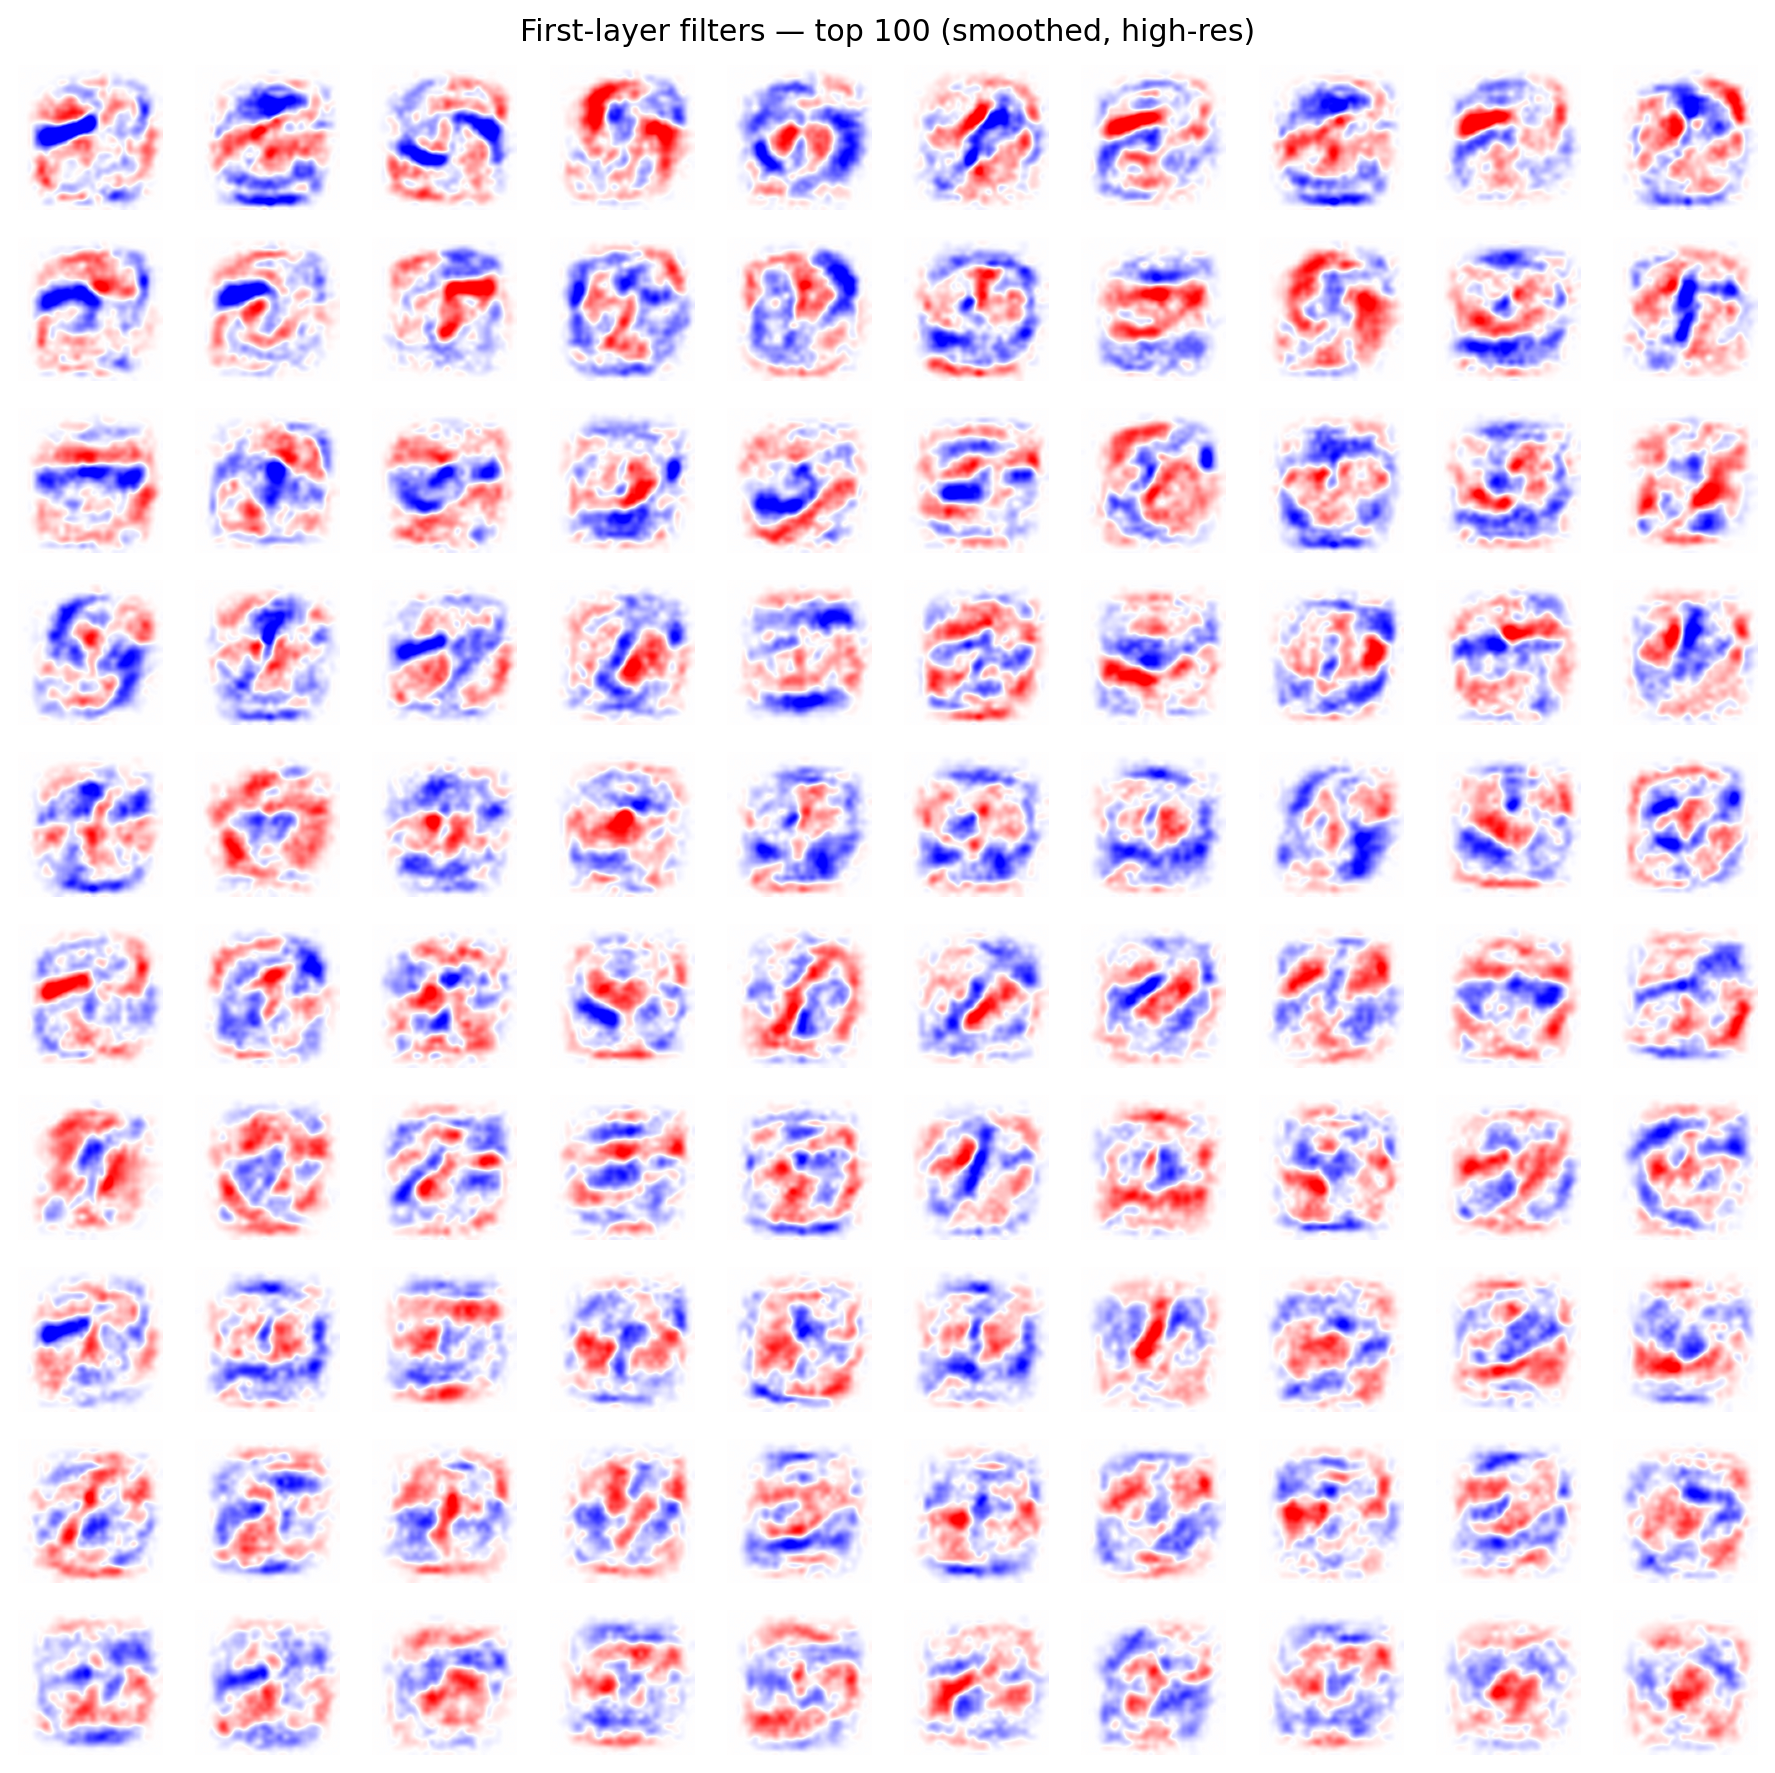

In [40]:

W1, b1, W2, b2, W3, b3 = get_Wb(model)

norms = np.linalg.norm(W1, axis=1)
order = np.argsort(-norms)  # descending
sel = order[:100]

vmax = float(np.percentile(np.abs(W1[sel]), 99)); vmax = max(vmax, 1e-6)
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

fig, axes = plt.subplots(10, 10, figsize=(10,10), dpi=180)
fig.suptitle("First-layer filters — top 100 (smoothed, high-res)")

for ax, j in zip(axes.ravel(), sel):
    w = W1[j].reshape(28,28)
    #w = gaussian_blur_np(w, sigma=0.9, k=7)
    wt = torch.from_numpy(w).float().unsqueeze(0).unsqueeze(0)
    w_up = F.interpolate(wt, size=(220,220), mode="bicubic", align_corners=False).squeeze().numpy()
    im = ax.imshow(w_up, cmap="bwr", norm=norm, interpolation="lanczos")
    #ax.contour(w_up, levels=[0], linewidths=0.7, colors="k")
    ax.axis("off")

#cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7, pad=0.02)
#cbar.set_label("Weight value (TwoSlopeNorm centered at 0)")
plt.tight_layout(); plt.show()


### W2

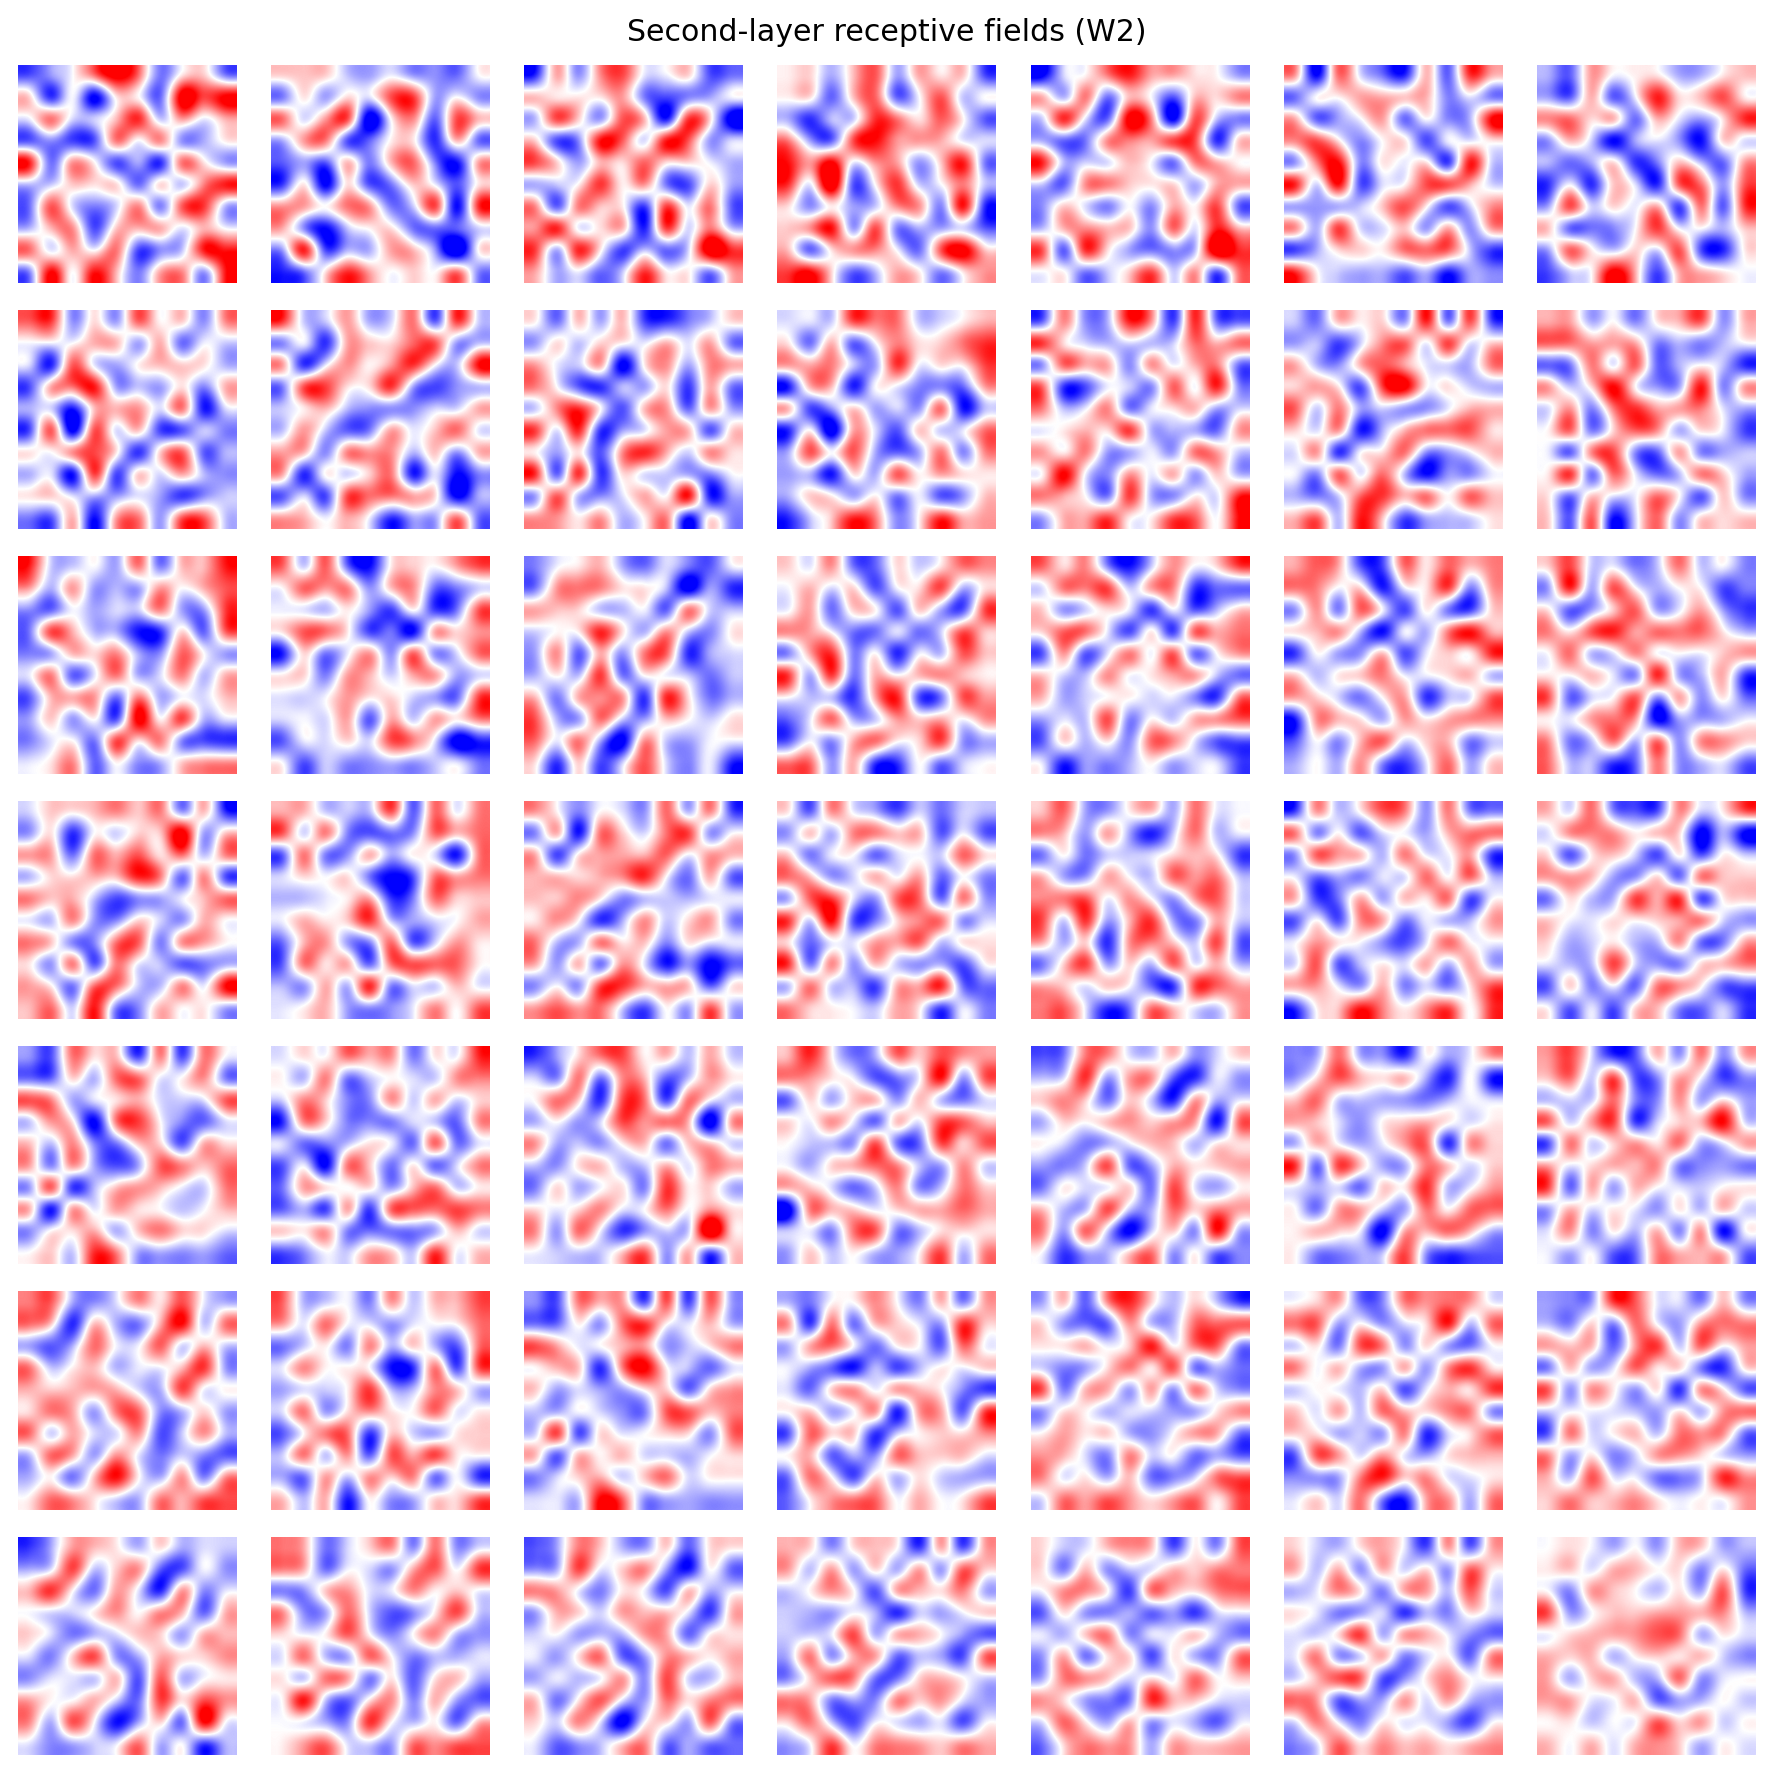

In [39]:
W2_back = W2   # (49, 100)

norms2 = np.linalg.norm(W2_back, axis=1)
order2 = np.argsort(-norms2)
sel2 = order2[:49]

vmax = float(np.percentile(np.abs(W2_back[sel2]), 99)); vmax = max(vmax, 1e-6)
norm2 = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

fig, axes = plt.subplots(7, 7, figsize=(10,10), dpi=180)
fig.suptitle("Second-layer receptive fields (W2)")

for ax, j in zip(axes.ravel(), sel2):
    w = W2_back[j].reshape(10,10)
    #w = gaussian_blur_np(w, sigma=0.9, k=7)
    wt = torch.from_numpy(w).float().unsqueeze(0).unsqueeze(0)
    w_up = F.interpolate(wt, size=(220,220), mode="bicubic", align_corners=False).squeeze().numpy()
    im = ax.imshow(w_up, cmap="bwr", norm=norm2, interpolation="lanczos")
    #ax.contour(w_up, levels=[0], linewidths=0.7, colors="k")
    ax.axis("off")

#cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7, pad=0.02)
#cbar.set_label("Weight value")
plt.tight_layout(); plt.show()


### W2 • W1

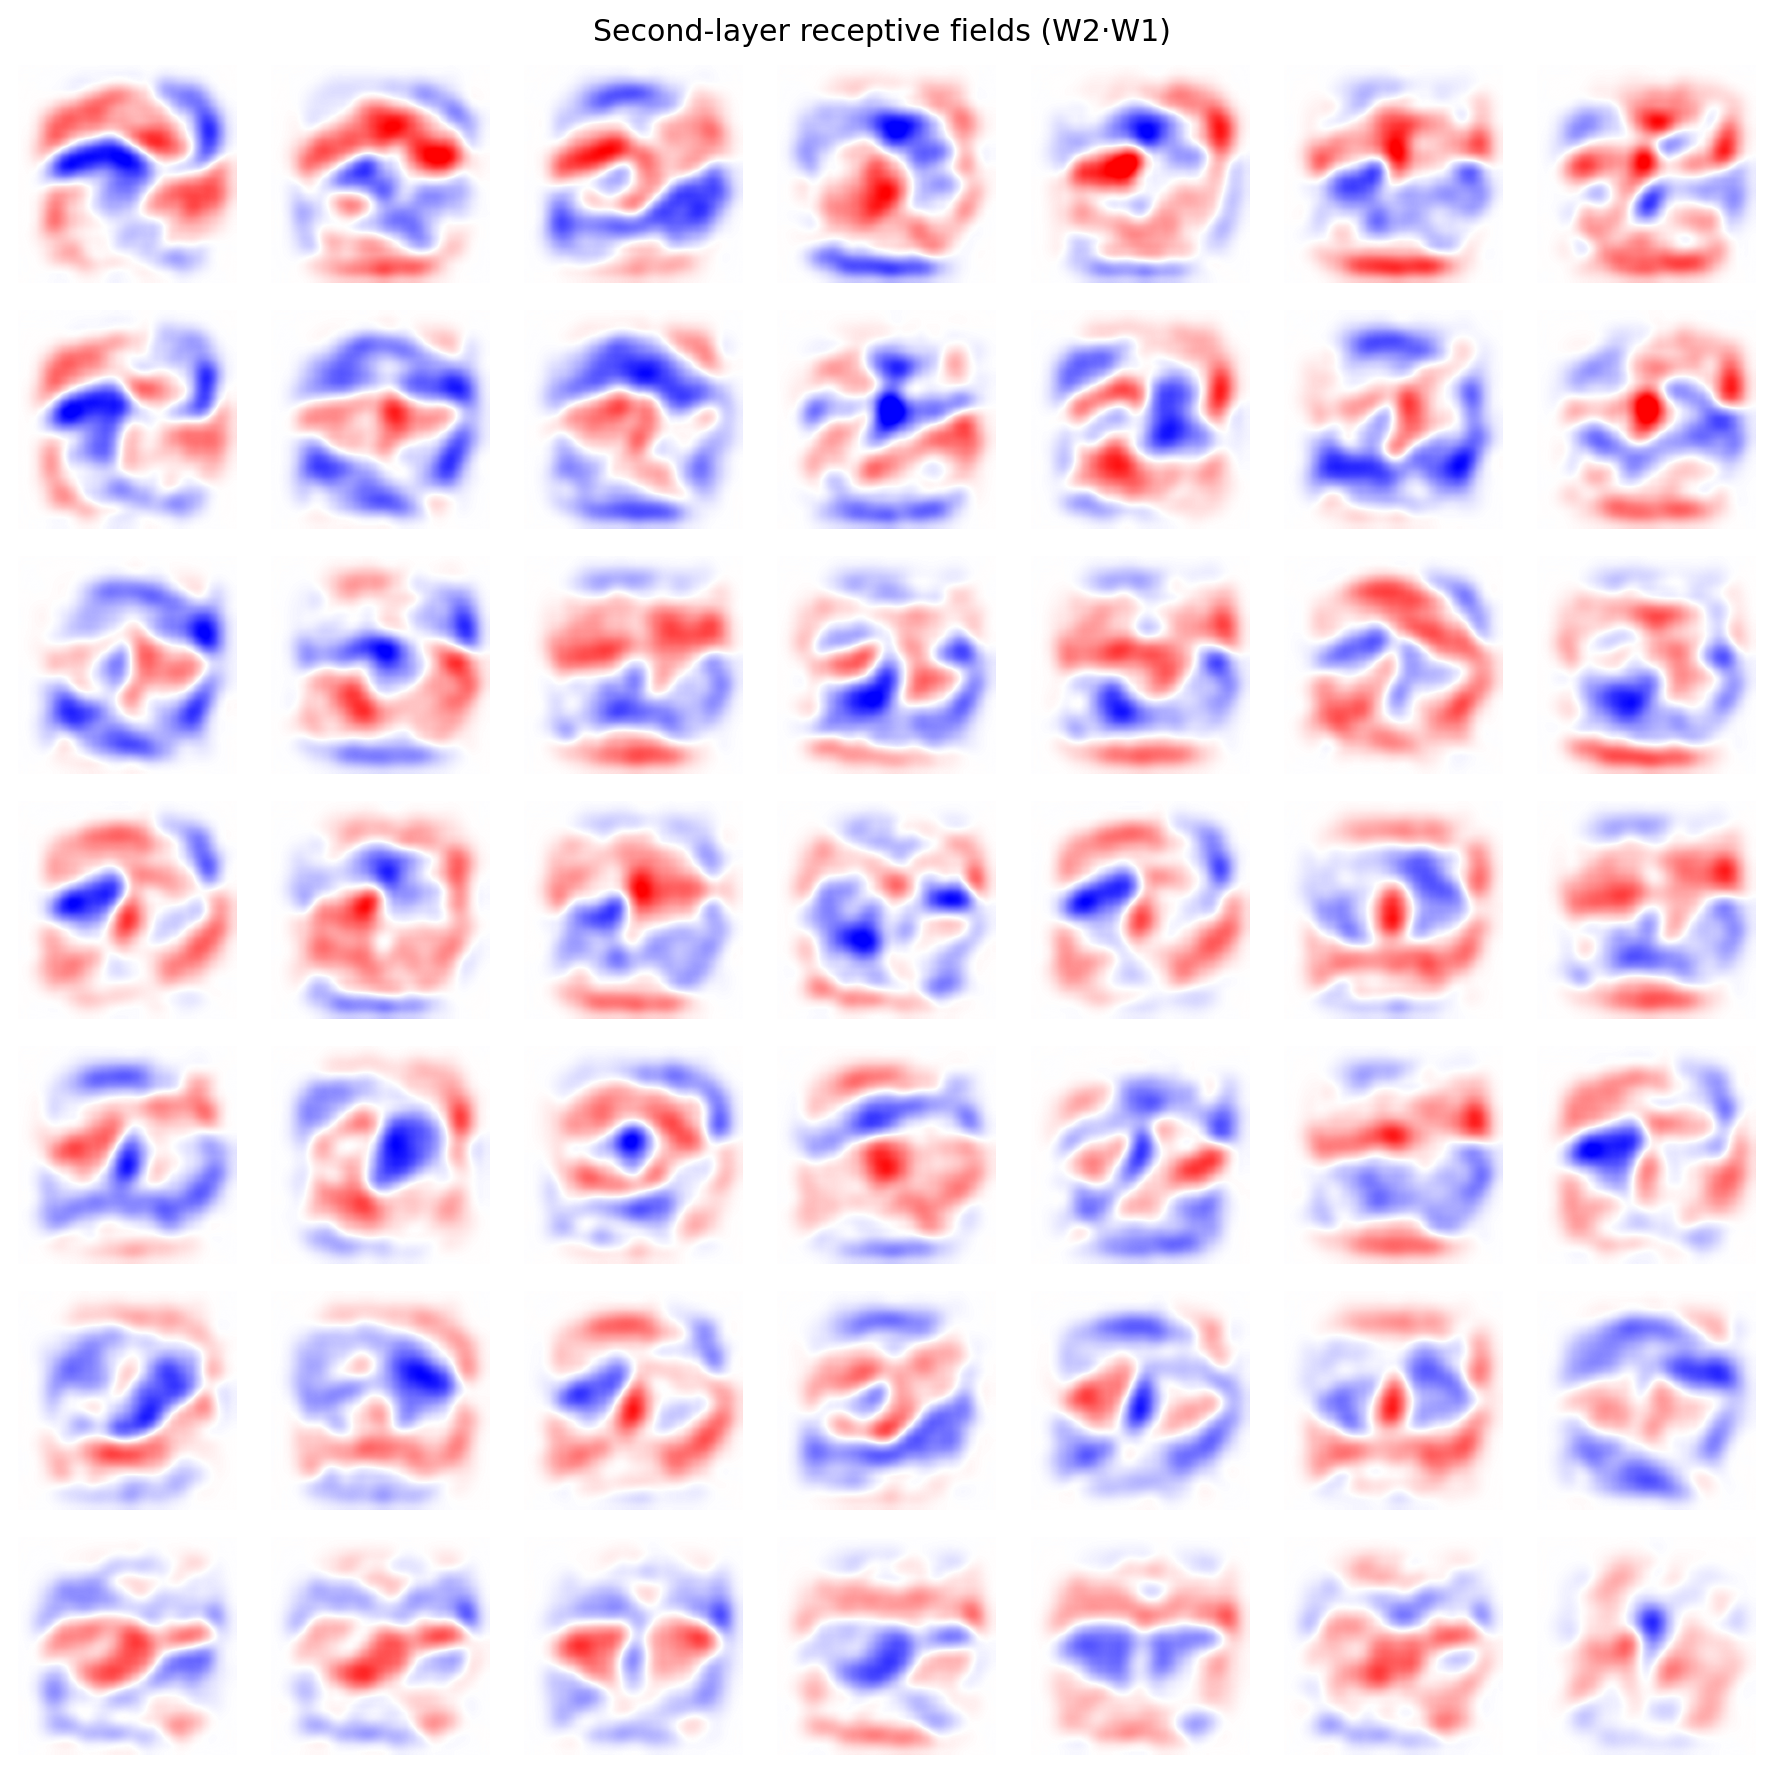

In [41]:

W2_back = W2 @ W1  # (49, 784)

norms2 = np.linalg.norm(W2_back, axis=1)
order2 = np.argsort(-norms2)
sel2 = order2[:49]

vmax = float(np.percentile(np.abs(W2_back[sel2]), 99)); vmax = max(vmax, 1e-6)
norm2 = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

fig, axes = plt.subplots(7, 7, figsize=(10,10), dpi=180)
fig.suptitle("Second-layer receptive fields (W2·W1) ")

for ax, j in zip(axes.ravel(), sel2):
    w = W2_back[j].reshape(28,28)
    w = gaussian_blur_np(w, sigma=0.9, k=7)
    wt = torch.from_numpy(w).float().unsqueeze(0).unsqueeze(0)
    w_up = F.interpolate(wt, size=(220,220), mode="bicubic", align_corners=False).squeeze().numpy()
    im = ax.imshow(w_up, cmap="bwr", norm=norm2, interpolation="lanczos")
    #ax.contour(w_up, levels=[0], linewidths=0.7, colors="k")
    ax.axis("off")

#cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7, pad=0.02)
#cbar.set_label("Weight value")
plt.tight_layout(); plt.show()


### W3

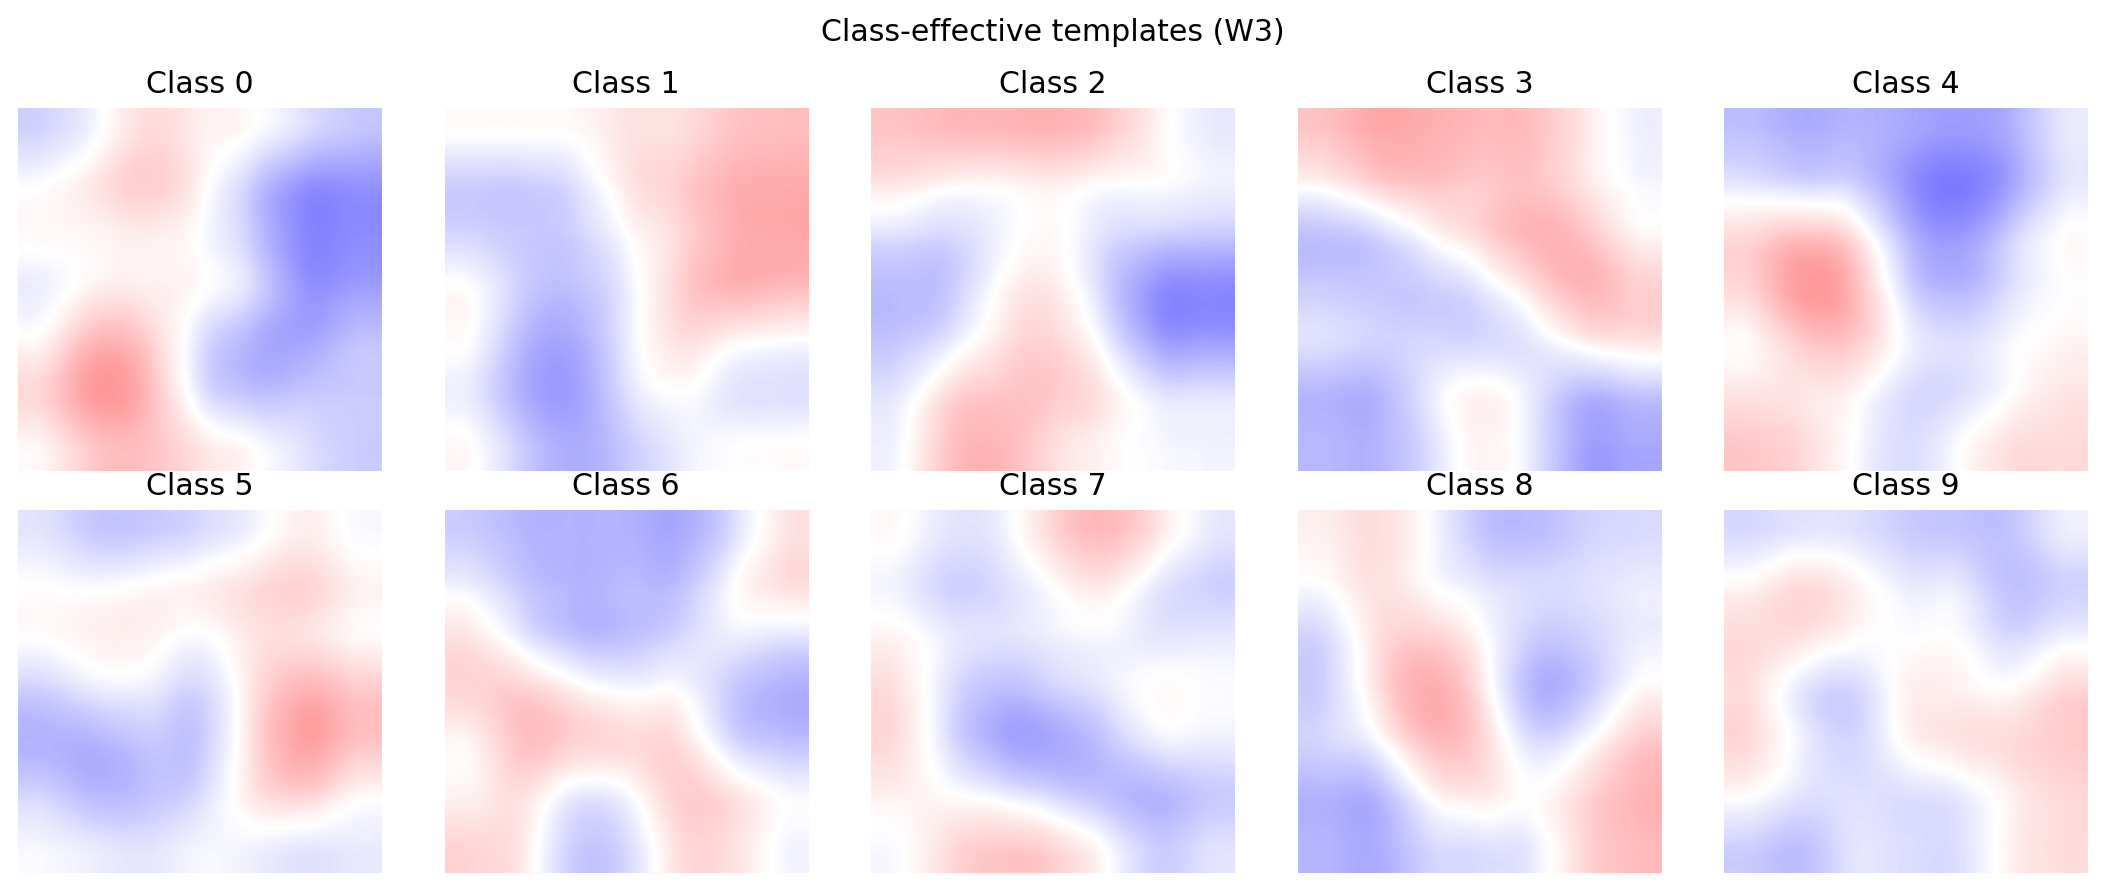

In [47]:

W_eff = W3  # (10, 49)

vmax = float(np.percentile(np.abs(W_eff), 99)); vmax = max(vmax, 1e-6)
norm3 = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

fig, axes = plt.subplots(2, 5, figsize=(12,5), dpi=180)
fig.suptitle("Class‑effective templates (W3)")

for k, ax in enumerate(axes.ravel()):
    wk = W_eff[k].reshape(7,7)
    wk = gaussian_blur_np(wk, sigma=0.9, k=7)
    wkt = torch.from_numpy(wk).float().unsqueeze(0).unsqueeze(0)
    wk_up = F.interpolate(wkt, size=(320,320), mode="bicubic", align_corners=False).squeeze().numpy()
    im = ax.imshow(wk_up, cmap="bwr", norm=norm3, interpolation="lanczos")
    ax.set_title(f"Class {k}"); ax.axis("off")

plt.tight_layout(); plt.show()


###  W3 • W2 • W1 

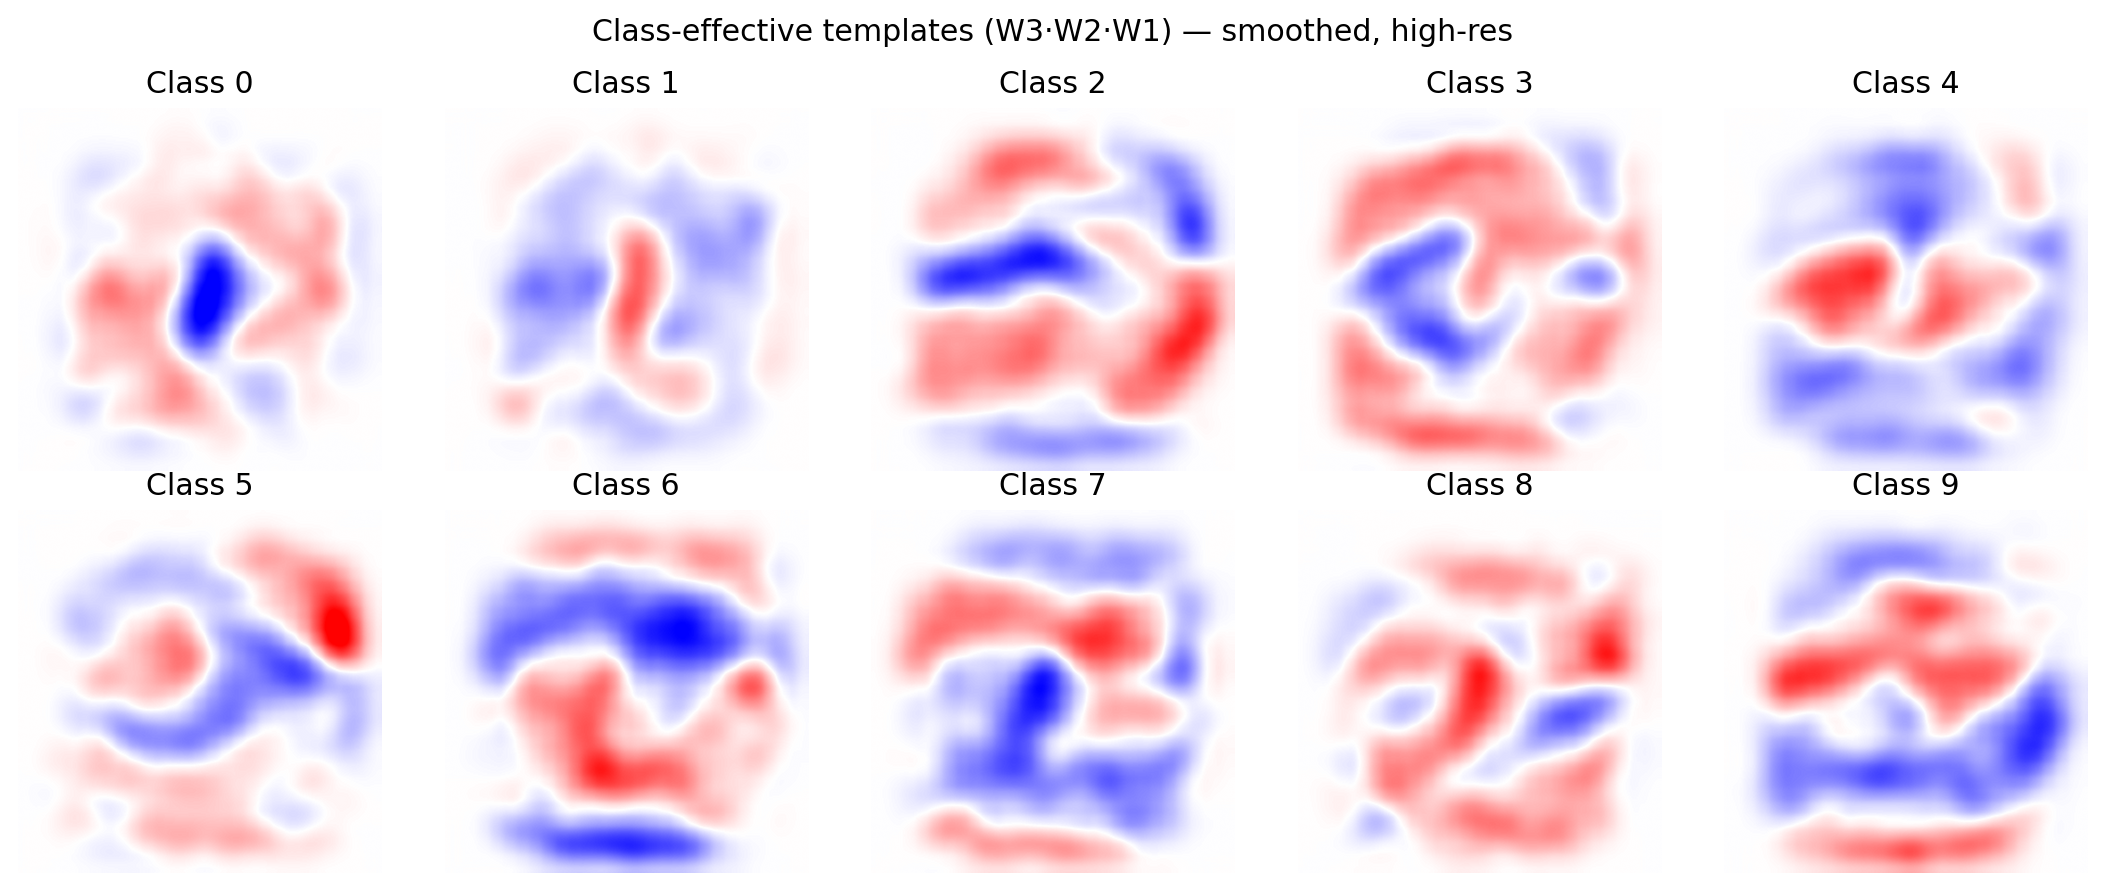

In [46]:

W_eff = W3 @ W2 @ W1  # (10, 784)

vmax = float(np.percentile(np.abs(W_eff), 99)); vmax = max(vmax, 1e-6)
norm3 = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

fig, axes = plt.subplots(2, 5, figsize=(12,5), dpi=180)
fig.suptitle("Class‑effective templates (W3·W2·W1) — smoothed, high‑res")

for k, ax in enumerate(axes.ravel()):
    wk = W_eff[k].reshape(28,28)
    wk = gaussian_blur_np(wk, sigma=0.9, k=7)
    wkt = torch.from_numpy(wk).float().unsqueeze(0).unsqueeze(0)
    wk_up = F.interpolate(wkt, size=(320,320), mode="bicubic", align_corners=False).squeeze().numpy()
    im = ax.imshow(wk_up, cmap="bwr", norm=norm3, interpolation="lanczos")
    ax.set_title(f"Class {k}"); ax.axis("off")
plt.tight_layout(); plt.show()


## 5) Quick prediction demo

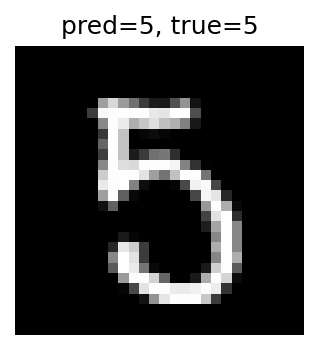

In [28]:

i = 207
x, y = test_ds[i]
with torch.no_grad():
    pred = model(x.unsqueeze(0).to(DEVICE)).argmax(dim=1).item()
plt.figure(figsize=(2.5,2.5), dpi=150)
plt.imshow(x.squeeze(0), cmap="gray")
plt.title(f"pred={pred}, true={y}")
plt.axis("off"); plt.show()



## Notes
- The **architecture matches** your Keras notebook: 784→100→49→10 with **sigmoid** hidden layers.
- For interpretability, we show (a) first-layer filters, (b) second-layer receptive fields projected to input, and (c) per‑class templates (approx \(W_3 W_2 W_1\)).
- **TwoSlopeNorm** keeps zero centered so positive/negative are balanced; **blur + upsampling** improves readability.
- GPU selection is automatic (CUDA → MPS → CPU).
